   # 1. 데이터 준비

In [106]:
import numpy as np 
import matplotlib.pyplot as plt

######pfcn.npz 데이터 로드###
data = np.load('pfcn.npz')
train_images = data['train_images'] 
test_images = data['test_images']

np.shape(test_images),np.shape(train_images)

((300, 100, 75, 3), (1700, 100, 75, 3))

In [107]:
##### y 데이터 구성##########
ydata = np.concatenate([train_images, test_images])

(2000, 100, 75, 3)

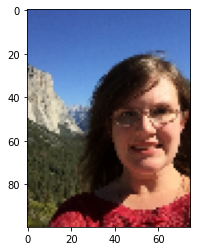

In [109]:
### y 데이터 사진 및 shape 확인####
plt.figure(figsize=(15,4))
plt.imshow(ydata[0])
np.shape(ydata) 

In [110]:
# ydata type은 int64로, cvtcolor는 uint16, uint32만 지원. 
# 근데 uint16,uint32 로 astype을 이용해 형변환하면 데이터손실이 일어나 그냥 검은색사진이 된다. 
# 이게 다 데이터가 (-1,1) 사이의 값을 가지고 있어서 생기는 문제이다. 
# 0~255 사이의 값을 가지도록 이미지를 바꿔주자.

# 참고:https://www.pythonfixing.com/2021/10/fixed-opencv-unsupported-depth-of-input.html

(<matplotlib.image.AxesImage at 0x187131c4108>, dtype('uint8'))

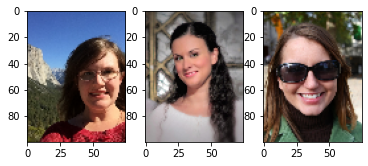

In [111]:
# YDATA 데이터 형변환
import cv2


ydata = cv2.normalize(ydata, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

ydata = ydata.astype(np.uint8)
                     
# 제대로 변환됐는지 확인
plt.subplot(1,3,1)
plt.imshow(ydata[0]), ydata[0].dtype

plt.subplot(1,3,2)
plt.imshow(ydata[299]), ydata[299].dtype

plt.subplot(1,3,3)
plt.imshow(ydata[1999]), ydata[1999].dtype

# 1-2. x 데이터 제작

In [112]:
import cv2

# haarcascade 불러오기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

total_data_length = len(ydata) # 이미지 개수
faces_coordinate = [] # 좌표 저장 리스트

for index in range(0 ,total_data_length):
    # 이미지 불러오기
    image = ydata[index]
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces_coordinate.extend(face_cascade.detectMultiScale(gray_image, 1.0893, 1, )) ###이미지내 얼굴 영역 좌표를 받아 옵니다.
    
 



In [113]:
len(faces_coordinate) #이걸로 만족...

2000

In [114]:
# 모자이크 처리

import copy

temp = copy.deepcopy(ydata)
mosaic_rate = 7 # 모자이크 배율
 
xdata =[] # 모자이크 이미지 저장할 리스트


for (x, y, w, h), image in zip(faces_coordinate, temp):
    face_img = image[y:y+h, x:x+w]  # 얼굴 영역 크롭

    face_img = cv2.resize(face_img, (mosaic_rate, mosaic_rate)) # 크롭한 이미지 지정된 배율로 축소
        
    face_img = cv2.resize(face_img, (w, h), interpolation=cv2.INTER_AREA) # 축소한 이미지 원래 크기로 돌리기(이때 화질이 깨지면서 모자이크 효과가 남)

    image[y:y+h, x:x+w] = face_img  # 크롭한 이미지를 좌표에 맞게 원래 이미지에 붙여넣기
    
    xdata.append(image)
 


xdata 개수:2000
xdata 타입:<class 'list'>


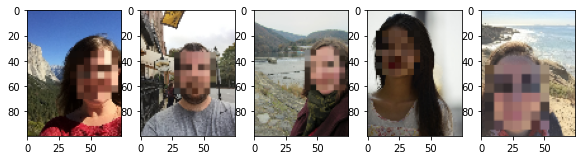

In [115]:
# xdata 개수 및 모자이크 이미지 확인
print('xdata 개수:'+ str(len(xdata))  + '\nxdata 타입:' + str((type(xdata))))

plt.figure(figsize=(20,10))
plt.subplot(1,10,1)
plt.imshow(xdata[0])

plt.subplot(1,10,2)
plt.imshow(xdata[1])

plt.subplot(1,10,3)
plt.imshow(xdata[2])

plt.subplot(1,10,4)
plt.imshow(xdata[3])

plt.subplot(1,10,5)
plt.imshow(xdata[4])



In [116]:
# xdata를 array로 바꾸어줍니다
xdata = np.array(xdata)
type(xdata)

numpy.ndarray

In [117]:
def shapecheck(*dataset):
    for data in dataset:
        print(np.shape(data))
shapecheck(xdata, ydata)

(2000, 100, 75, 3)
(2000, 100, 75, 3)


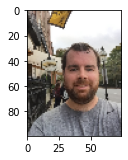

In [118]:
plt.figure(figsize=(20,10))
plt.subplot(1,10,1)
plt.imshow(ydata[1])

In [119]:
real_x = xdata/255
real_y = ydata/255
# 이미지가 0에서 1사이의 값이 나오도록해줍니다.

# 2. train/ test data 제작

In [133]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train, y_test= train_test_split(real_x, real_y,test_size=0.2, random_state=111)

In [134]:
shapecheck(x_train, y_train, x_test, y_test)

(1600, 100, 75, 3)
(1600, 100, 75, 3)
(400, 100, 75, 3)
(400, 100, 75, 3)


# 3. 모델제작 

In [141]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_like():
    inputs = Input((100, 75, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, (1,1), activation="sigmoid")(c9)

    model = Model(inputs, outputs)
    return model


In [142]:
model_unet = unet_like()
model_unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 100, 75, 16)  448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 100, 75, 16)  64          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 100, 75, 16)  0           batch_normalization_90[0][0]     
____________________________________________________________________________________________

In [143]:
model_unet.compile(loss="mse",optimizer="adam", metrics=["accuracy"])

In [144]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath=".\\Ch14-4-bestmodel.hdf5"


checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

In [145]:
hist = model_unet.fit(x_train, y_train, validation_data=(x_test, y_test), validation_steps=1, callbacks=[checkpointer], epochs=20)

Epoch 1/20
50/50 [==============================] - 18s 252ms/step - loss: 0.0275 - accuracy: 0.5610 - val_loss: 0.0644 - val_accuracy: 0.6990
Epoch 2/20
50/50 [==============================] - 12s 230ms/step - loss: 0.0121 - accuracy: 0.6913 - val_loss: 0.0505 - val_accuracy: 0.7437
Epoch 3/20
50/50 [==============================] - 12s 230ms/step - loss: 0.0100 - accuracy: 0.7306 - val_loss: 0.0374 - val_accuracy: 0.7064
Epoch 4/20
50/50 [==============================] - 11s 230ms/step - loss: 0.0091 - accuracy: 0.7577 - val_loss: 0.0294 - val_accuracy: 0.6844
Epoch 5/20
50/50 [==============================] - 11s 230ms/step - loss: 0.0085 - accuracy: 0.7758 - val_loss: 0.0220 - val_accuracy: 0.6823
Epoch 6/20
50/50 [==============================] - 11s 230ms/step - loss: 0.0082 - accuracy: 0.7848 - val_loss: 0.0156 - val_accuracy: 0.7465
Epoch 7/20
50/50 [==============================] - 12s 230ms/step - loss: 0.0078 - accuracy: 0.7881 - val_loss: 0.0127 - val_accuracy: 0.7806

<Figure size 864x288 with 0 Axes>

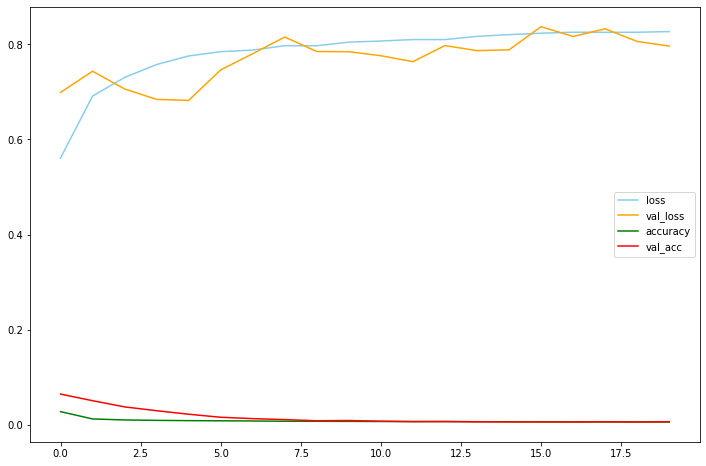

In [146]:
# 모델 결과 시각화
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'],c='skyblue')
plt.plot(hist.history['val_accuracy'],c='orange')
plt.plot(hist.history['loss'],c='green')
plt.plot(hist.history['val_loss'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

# 모델 예측

Text(0.5, 1.0, 'model_result')

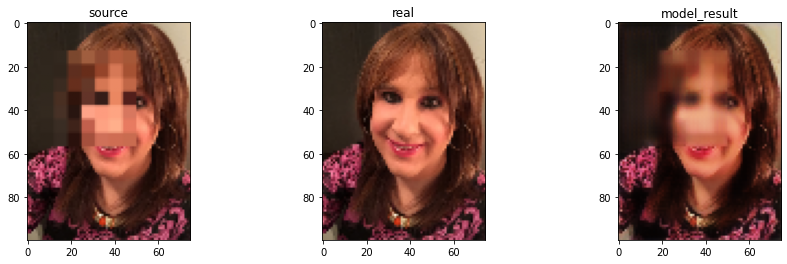

In [147]:
source = x_test[:100]
real = y_test[:100]
model_result = model_unet.predict(x_test[:100])

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(source[99])
plt.title('source')

plt.subplot(1,3,2)
plt.imshow(real[99])
plt.title('real')

plt.subplot(1,3,3)
plt.imshow(model_result[99])
plt.title('model_result')